# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

Trained with an updated model architecture, CNNMFCCs2


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs_2'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Import EarlyStopping class


In [9]:
from models.EarlyStopping import EarlyStopping

Define what happens in each epoch


In [10]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    early_stopper = EarlyStopping(path=f'earlystop_{MODEL}.pt')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best validation accuracy model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

        # Check for early stopping (based on val_loss)
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            break

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [11]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [13]:
from CNNMFCCs2 import CNNMFCCs2

model = CNNMFCCs2()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs2(
  (conv1): Conv1d(40, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

Visualize the model


In [14]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 172]           3,872
       BatchNorm1d-2              [-1, 32, 172]              64
            Conv1d-3               [-1, 64, 86]           6,208
       BatchNorm1d-4               [-1, 64, 86]             128
            Conv1d-5              [-1, 128, 43]          24,704
       BatchNorm1d-6              [-1, 128, 43]             256
            Conv1d-7              [-1, 256, 21]          98,560
       BatchNorm1d-8              [-1, 256, 21]             512
 AdaptiveAvgPool1d-9               [-1, 256, 1]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 9]           1,161
Total params: 168,361
Trainable params:

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 56.63it/s, Loss=1.074703574180603, Elapsed=1.8652s, ETA=0.0000s] 


Epoch 1 completed in 8.3140s
Train Loss: 1.3106563232537638 - Train Accuracy: 42.87781823115714
Validation Loss: 1.1383725452423095 - Validation Accuracy: 49.26129168425496

Epoch 2/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 58.31it/s, Loss=0.7099344730377197, Elapsed=1.7402s, ETA=0.0000s]

Epoch 2 completed in 7.3746s
Train Loss: 1.0222319166439806 - Train Accuracy: 54.79297166504602
Validation Loss: 0.9269697729746501 - Validation Accuracy: 61.27057830308147

Epoch 3/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.97it/s, Loss=1.0928351879119873, Elapsed=1.7127s, ETA=0.0000s]

Epoch 3 completed in 7.7252s
Train Loss: 0.9170263559487514 - Train Accuracy: 59.41068723004908
Validation Loss: 0.8449974171320598 - Validation Accuracy: 62.65301815111861

Epoch 4/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.85it/s, Loss=0.6434101462364197, Elapsed=1.6134s, ETA=0.0000s]

Epoch 4 completed in 7.1735s
Train Loss: 0.8572780340048619 - Train Accuracy: 62.449967210149026
Validation Loss: 0.8426478457450867 - Validation Accuracy: 63.782186576614606

Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.82it/s, Loss=0.8243238925933838, Elapsed=1.7317s, ETA=0.0000s]

Epoch 5 completed in 7.2847s
Train Loss: 0.8213673693940818 - Train Accuracy: 63.96508446213337
Validation Loss: 0.8155079102516174 - Validation Accuracy: 65.4073448712537

Epoch 6/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.86it/s, Loss=0.8915228247642517, Elapsed=1.6986s, ETA=0.0000s]

Epoch 6 completed in 7.2714s
Train Loss: 0.7866295984370171 - Train Accuracy: 65.5480427851021
Validation Loss: 0.9450120488802592 - Validation Accuracy: 61.1439425918109

EarlyStopping counter: 1/5
Epoch 7/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.53it/s, Loss=0.42643076181411743, Elapsed=1.7369s, ETA=0.0000s]

Epoch 7 completed in 7.7614s
Train Loss: 0.7497492337847032 - Train Accuracy: 67.11291015580832
Validation Loss: 0.8048863855997721 - Validation Accuracy: 67.26466863655551

Epoch 8/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.35it/s, Loss=0.723846435546875, Elapsed=1.6825s, ETA=0.0000s] 


Epoch 8 completed in 7.7355s
Train Loss: 0.7289073841937016 - Train Accuracy: 67.92926437665363
Validation Loss: 0.7635200373331705 - Validation Accuracy: 68.16167159138877

Epoch 9/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.08it/s, Loss=0.44000881910324097, Elapsed=1.7186s, ETA=0.0000s]

Epoch 9 completed in 7.4520s
Train Loss: 0.7085262736833164 - Train Accuracy: 68.93783496528798
Validation Loss: 0.8198495761553446 - Validation Accuracy: 65.95609962009287

EarlyStopping counter: 1/5
Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.86it/s, Loss=0.33187955617904663, Elapsed=1.6814s, ETA=0.0000s]

Epoch 10 completed in 7.6269s
Train Loss: 0.6902251039454014 - Train Accuracy: 69.69765496031297
Validation Loss: 0.7100100922584534 - Validation Accuracy: 67.99282397636134

Epoch 11/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.43it/s, Loss=0.3260044455528259, Elapsed=1.6209s, ETA=0.0000s]

Epoch 11 completed in 7.5402s
Train Loss: 0.6707087060964176 - Train Accuracy: 70.51627055019108
Validation Loss: 0.7056489650408427 - Validation Accuracy: 70.36724356268468

Epoch 12/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.34it/s, Loss=0.18260520696640015, Elapsed=1.7482s, ETA=0.0000s]

Epoch 12 completed in 7.8079s
Train Loss: 0.6555211966092875 - Train Accuracy: 71.37785215169264
Validation Loss: 0.7124977882703145 - Validation Accuracy: 68.69987336428873

EarlyStopping counter: 1/5
Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.05it/s, Loss=0.39449042081832886, Elapsed=1.7266s, ETA=0.0000s]

Epoch 13 completed in 7.3760s
Train Loss: 0.6405823362528245 - Train Accuracy: 71.73967119694264
Validation Loss: 0.7097843515872956 - Validation Accuracy: 70.34613761080625

EarlyStopping counter: 2/5
Epoch 14/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.21it/s, Loss=0.3610419034957886, Elapsed=1.7343s, ETA=0.0000s]

Epoch 14 completed in 7.4065s
Train Loss: 0.6235145736980989 - Train Accuracy: 72.44747970421294
Validation Loss: 0.6893300410111746 - Validation Accuracy: 70.55719712959055

Epoch 15/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.46it/s, Loss=0.22738666832447052, Elapsed=1.6352s, ETA=0.0000s]


Epoch 15 completed in 7.2895s
Train Loss: 0.6071166685550888 - Train Accuracy: 73.24574297279574
Validation Loss: 0.6960108802715937 - Validation Accuracy: 71.82355424229632

EarlyStopping counter: 1/5
Epoch 16/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.20it/s, Loss=0.14117945730686188, Elapsed=1.6496s, ETA=0.0000s]

Epoch 16 completed in 7.2696s
Train Loss: 0.5976832328159685 - Train Accuracy: 73.66409624386604
Validation Loss: 0.6898796691497167 - Validation Accuracy: 71.79189531447868

EarlyStopping counter: 2/5
Epoch 17/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.35it/s, Loss=0.16867102682590485, Elapsed=1.6201s, ETA=0.0000s]

Epoch 17 completed in 7.2995s
Train Loss: 0.5788387777660623 - Train Accuracy: 74.12541552655978
Validation Loss: 0.7289739944537481 - Validation Accuracy: 71.84466019417476

EarlyStopping counter: 3/5
Epoch 18/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.09it/s, Loss=0.29750126600265503, Elapsed=1.5671s, ETA=0.0000s]

Epoch 18 completed in 7.1219s
Train Loss: 0.5732942817011321 - Train Accuracy: 74.75181474864884
Validation Loss: 0.6902558831373851 - Validation Accuracy: 73.80751371886872

EarlyStopping counter: 4/5
Epoch 19/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.75it/s, Loss=0.1493159979581833, Elapsed=1.6784s, ETA=0.0000s] 


Epoch 19 completed in 7.3926s
Train Loss: 0.5561655224920008 - Train Accuracy: 75.1814748648832
Validation Loss: 0.694507910211881 - Validation Accuracy: 72.10848459265513

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


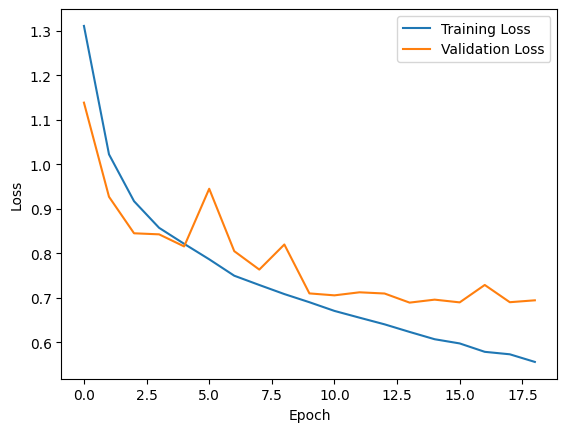

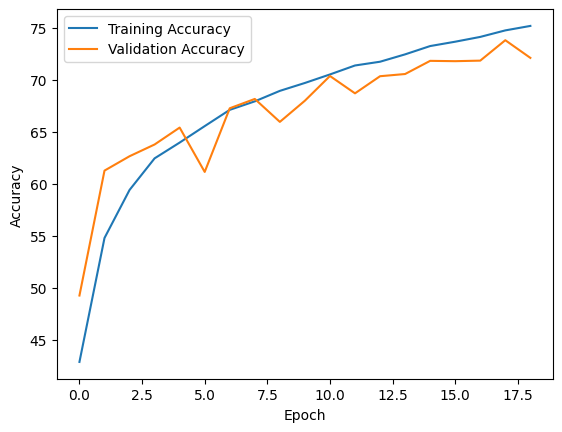

In [16]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [18]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:01<00:00, 40.17it/s]


Test Accuracy: 0.7263
Test Precision: 0.7531
Test Recall: 0.7263
Test F1-score: 0.7296

              precision    recall  f1-score   support

       Anger       0.79      0.78      0.79       916
       Bored       0.71      0.92      0.80      1098
     Disgust       0.47      0.62      0.53       291
        Fear       0.36      0.78      0.49       308
       Happy       0.84      0.58      0.69      1914
     Neutral       0.67      0.69      0.68      2226
    Question       0.85      0.86      0.86      1139
         Sad       0.83      0.67      0.74       857
    Surprise       0.84      0.73      0.78       728

    accuracy                           0.73      9477
   macro avg       0.71      0.74      0.71      9477
weighted avg       0.75      0.73      0.73      9477



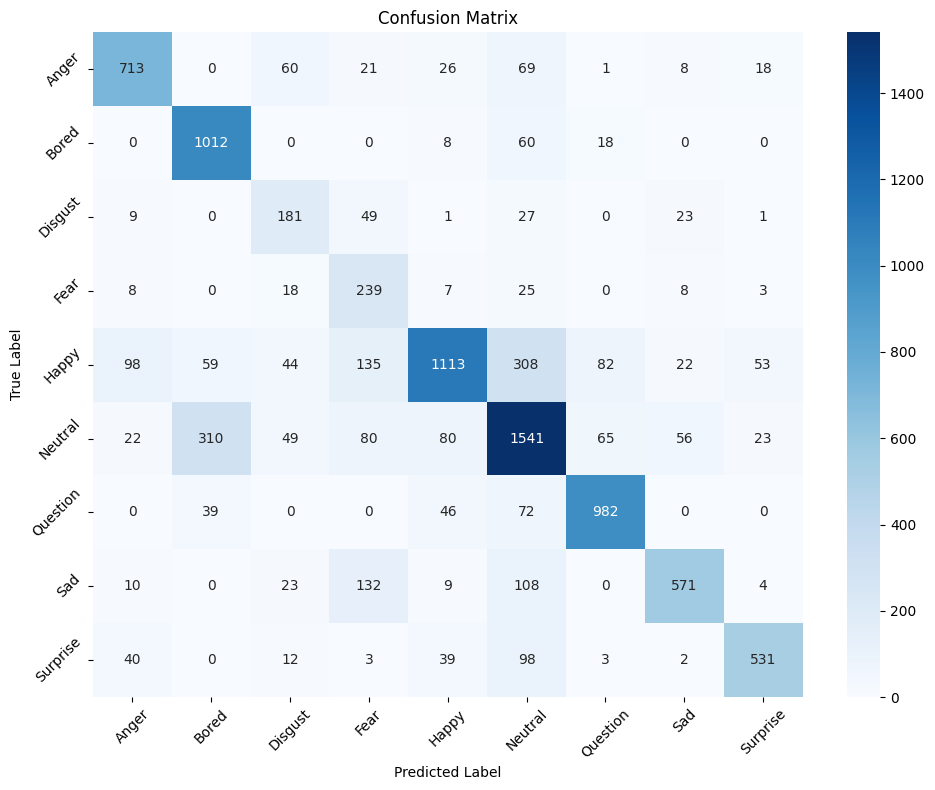

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)